## Import required libraries

In [139]:
import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output
from pathlib import Path
from PIL import Image
from keras.utils import plot_model
import time

## Set path, Scaling and display the content and style image

In [140]:
content_path = Path('/content/sachine.jpg')
style_path = Path('/content/style_image.jpg')


In [141]:
def load_img(path_to_img):  ## loads an image and scales it to 512 pixels
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image

def load_images(content_path, style_path):  ## loads the content and path images as tensors
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


## Display Image
def imshow(image, title=None):

  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def show_images_with_objects(images, titles=[]):
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)

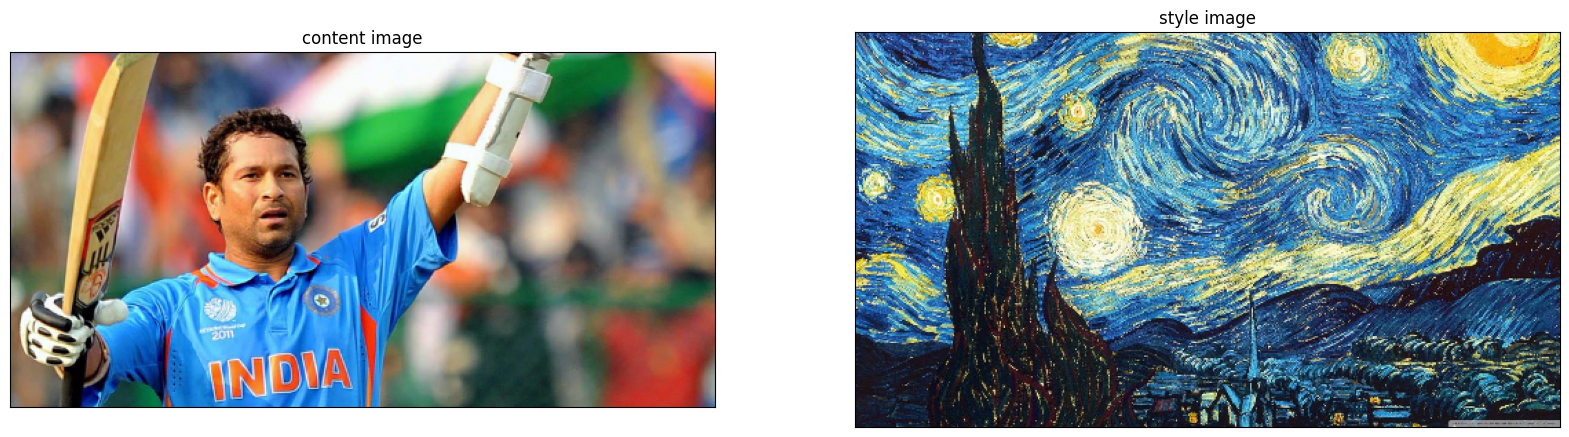

In [142]:
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image],titles=['content image','style image'])

# Download the inception model and inspect the layers

In [164]:
tmp_inception = tf.keras.applications.InceptionV3()
#tmp_inception.summary()
#plot_model(tmp_inception, to_file="model.png", show_shapes=True)

# choose the layers and put in a list

In [145]:
# choose the content layer and put in a list
content_layers = ['conv2d_93']

# choose the five style layers of interest
style_layers = ['conv2d',
                'conv2d_1',
                'conv2d_2',
                'conv2d_3',
                'conv2d_4']

# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers

# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

# Create model from layers
**args:**
* layer_names: a list of strings, representing the names of the desired content and style layers

**returns:**
* A model that takes the regular inception v3 input and outputs just the content and style layers.

In [146]:
def inception_model(layer_names):
  inception = tf.keras.applications.inception_v3.InceptionV3(include_top = False, weights= 'imagenet')

  # Freeze the weights of the model's layers (make them not trainable)
  inception.trainable = False

  # Create a list of layer objects that are specified by layer_names
  output_layers = [inception.get_layer(name).output for name in layer_names]

  # Create the model that outputs the content and style layers
  model = tf.keras.models.Model(inputs = inception.input, outputs = output_layers)

  return model

In [147]:
K.clear_session()

inception = inception_model(content_and_style_layers)
inception


# Defining loss functions

In [148]:
def get_style_loss(features, targets):

  # Calculate the style loss
  style_loss =  tf.reduce_mean(tf.square(features - targets))

  return style_loss


In [149]:
def get_content_loss(features, targets):
  # get the sum of the squared error multiplied by a scaling factor
  content_loss =  0.5 * tf.reduce_sum(tf.square(features - targets))

  return content_loss

In [150]:
def gram_matrix(input_tensor):
  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations

  return scaled_gram

In [151]:
tmp_layer_list = [layer.output for layer in inception.layers]

In [152]:
def preprocess_image(image):
  '''preprocesses a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

# Get the style image features
**Args:**
* image: an input image
    
**Returns:**
* gram_style_features: the style features as gram matrices



In [153]:
def get_style_image_features(image):
  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image)

  # get the outputs from the inception model that you created using inception_model()
  outputs = inception(preprocessed_style_image)

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features


# Get the content image features
**Args:**
* image: an input image
    
**Returns:**
* content_outputs: the content features of the image

In [154]:
def get_content_image_features(image):
  """ Get the content image features

  Args:
    image: an input image

  Returns:
    content_outputs: the content features of the image
  """
  # preprocess the image
  preprocessed_content_image = preprocess_image(image)

  # get the outputs from the inception model
  outputs = inception(preprocessed_content_image)

  # get the content layer of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  return content_outputs

# Combine the style and content loss
**Args:**
* style_targets: style features of the style image
* style_outputs: style features of the generated image
* content_targets: content features of the content image
* content_outputs: content features of the generated image
* style_weight: weight given to the style loss
* content_weight: weight given to the content loss

**Returns:**
* total_loss: the combined style and content loss

In [155]:
def get_style_content_loss(style_targets, style_outputs, content_targets,
                           content_outputs, style_weight, content_weight):
   # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])

  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss =  style_loss * style_weight / NUM_STYLE_LAYERS

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS

  # sum up the style and content losses
  total_loss = style_loss + content_loss

  # return the total loss
  return total_loss

#  Calculate the gradients of the loss with respect to the generated image

**Args:**
* image: generated image
* style_targets: style features of the style image
* content_targets: content features of the content image
* style_weight: weight given to the style loss
* content_weight: weight given to the content loss


  **Returns:**
  * gradients: gradients of the loss with respect to the input image

In [156]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight):

  with tf.GradientTape() as tape:

    # get the style image features
    style_features = get_style_image_features(image)

    # get the content image features
    content_features = get_content_image_features(image)

    # get the style and content loss
    loss =  get_style_content_loss(style_targets, style_features, content_targets,
                                  content_features, style_weight, content_weight)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image)

  return gradients


In [157]:
def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

In [158]:
def update_image_with_style(image, style_targets, content_targets, style_weight,
                            content_weight, optimizer):

  # Calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets,
                                  style_weight, content_weight)

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)])

  # Clip the image using the given clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [159]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)

# Performs neural style transfer
**Args:**
* style_image: image to get style features from
* content_image: image to stylize
* style_targets: style features of the style image
* content_targets: content features of the content image
* style_weight: weight given to the style loss
* content_weight: weight given to the content loss
* optimizer: optimizer for updating the input image
* epochs: number of epochs
* steps_per_epoch = steps per epoch

**Returns:**
* generated_image: generated image at final epoch
* images: collection of generated images per epoch  

In [160]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       optimizer='adam', epochs=1, steps_per_epoch=1):
    images = []
    step = 0

    # get the style image features
    style_targets = get_style_image_features(style_image)

    # get the content image features
    content_targets = get_content_image_features(content_image)

    # initialize the generated image for updates
    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image)

    # collect the image updates starting from the content image
    images.append(content_image)

    start_time = time.time()  # Record start time

    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1

            # Update the image with the style using the function that we defined
            update_image_with_style(generated_image, style_targets, content_targets,
                                    style_weight, content_weight, optimizer)

            print(".", end='')
            if (m + 1) % 10 == 0:
                images.append(generated_image)

        # display the current stylized image
        clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)

        # append to the image collection for visualization later
        images.append(generated_image)
        print("Train step: {}".format(step))

    end_time = time.time()  # Record end time
    training_time = end_time - start_time
    print("Training time: {:.2f} seconds".format(training_time))

    # convert to uint8 (expected dtype for images with pixels in the range [0,255])
    generated_image = tf.cast(generated_image, dtype=tf.uint8)

    # Save the final generated image
    tf.keras.preprocessing.image.save_img("resultant_image.jpg", tensor_to_image(generated_image))

    return generated_image, images



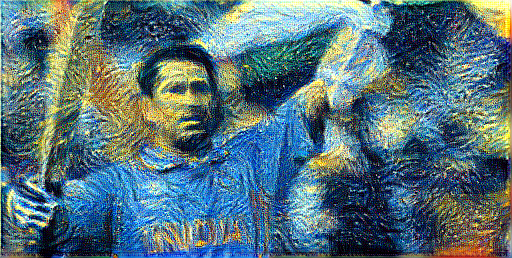

Train step: 1000
Training time: 457.74 seconds


In [161]:
# define style and content weight
style_weight =  0.35
content_weight = 1e-32

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))
#
# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)

# Conclusion

In [162]:
resultant_path = Path('/content/resultant_image.jpg')

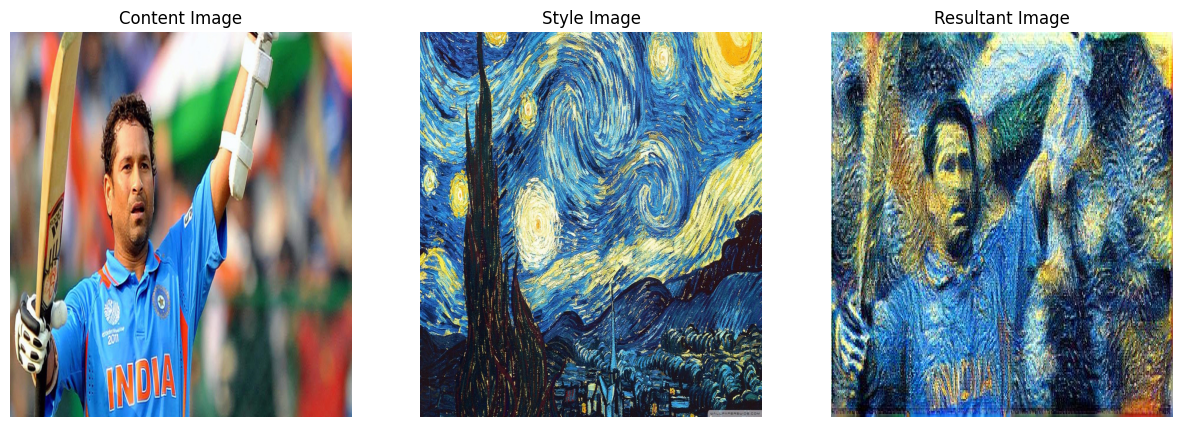

In [163]:
# Load images
content_image = Image.open(content_path)
style_image = Image.open(style_path)
resultant_image = Image.open(resultant_path)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display content image with title
axs[0].imshow(content_image, aspect='auto')
axs[0].set_title("Content Image")
axs[0].axis('off')

# Display style image with title
axs[1].imshow(style_image, aspect='auto')
axs[1].set_title("Style Image")
axs[1].axis('off')

# Display resultant image with title
axs[2].imshow(resultant_image, aspect='auto')
axs[2].set_title("Resultant Image")
axs[2].axis('off')

# Show the plot
plt.show()
